## 空间分析 (具有权重的热点分析)
python版本：2.7

核心第三方包：arcpy & geopandas

数据：
- [西安市内兴趣点数据](./poi_tables/)：excel格式，空间参考4326(经度字段：lng，维度字段：lat)
   - edu：教育 (权重 * 2)
   - food：餐饮 (权重 * 3)
   - infrastructure：基础设施 (权重 * 1)
   - medicine：医疗 (权重 * 1)
   - shopping：购物 (权重 * 3)
   - siteseeing：景点 (权重 * 5)
- [西安市行政区划](./xian)：shapefile文件，包含西安市各区

PS：该分析方式以及权重赋值均没有依据，该练习主要目的是对相关函数与工具的使用，若需要设计分析模型，请参考其他资源

In [1]:
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import geopandas as gpd

In [4]:
import os

In [5]:
import arcpy

In [6]:
table_dir = "./poi_tables/"

In [7]:
gdb = "./poi_tables/poi_nb.gdb"

In [8]:
if not os.path.exists(gdb):
    arcpy.CreateFileGDB_management(table_dir,"poi_nb.gdb" )

In [9]:
arcpy.env.workspace = gdb

In [10]:
arcpy.env.overwriteOutput = True

### 将Excel中的poi数据导入GDB中

Created Feature Class edu
Created Feature Class food
Created Feature Class infrastructure
Created Feature Class medicine
Created Feature Class shopping
Created Feature Class siteseeing


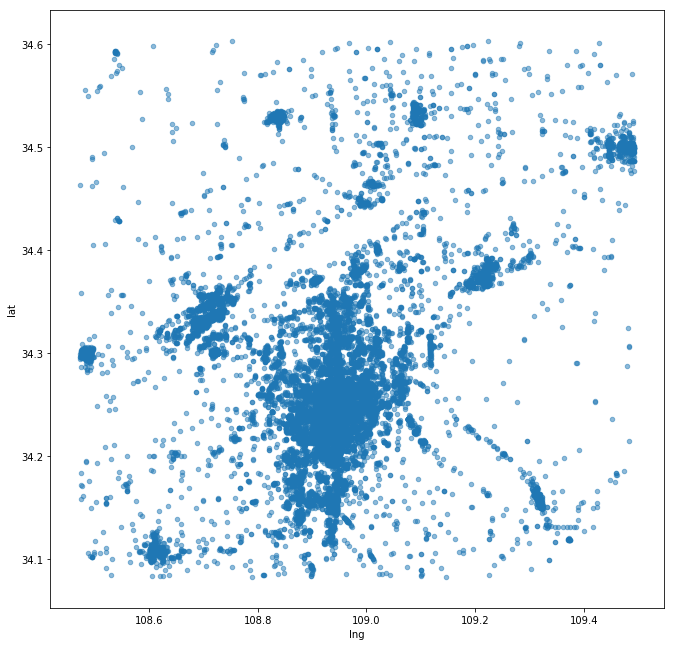

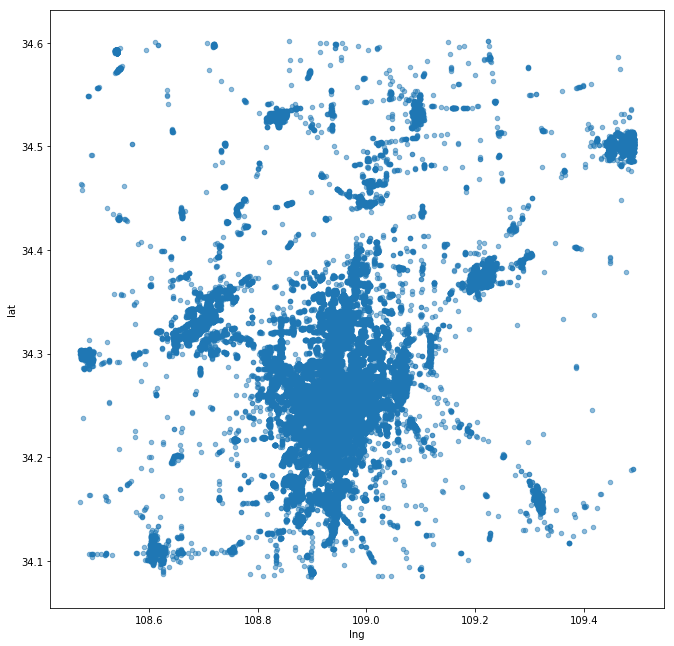

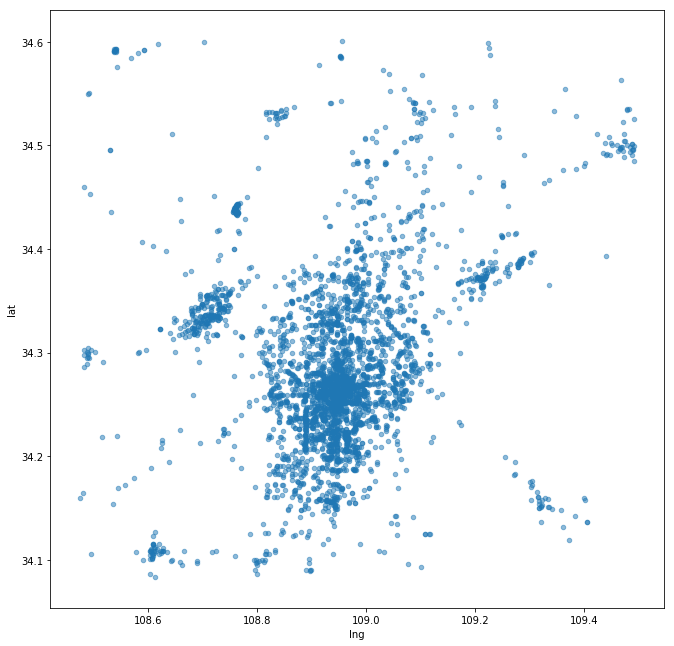

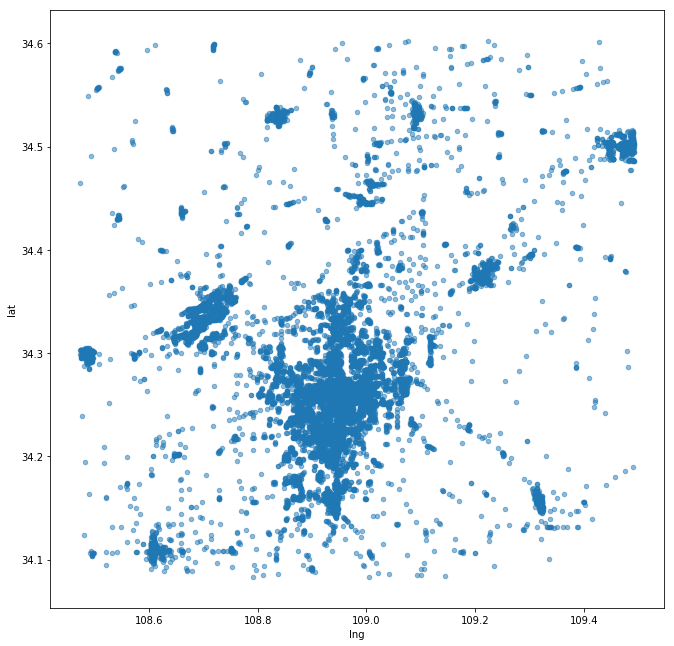

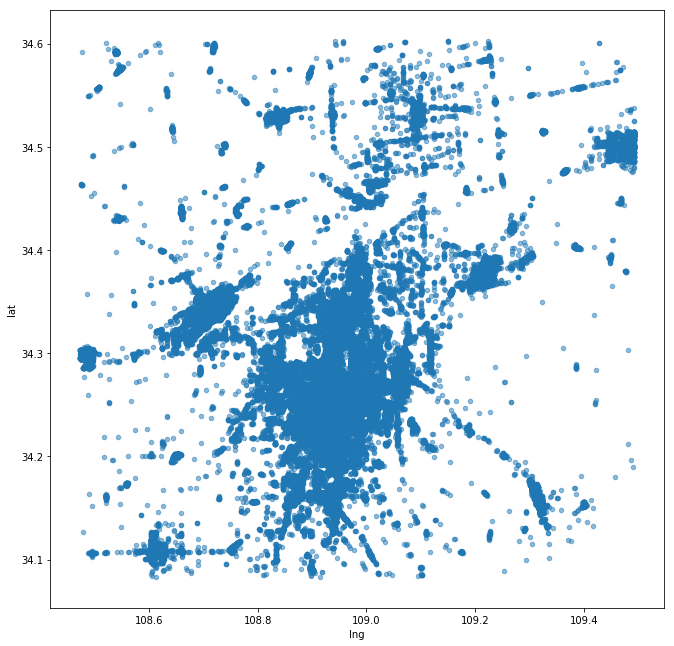

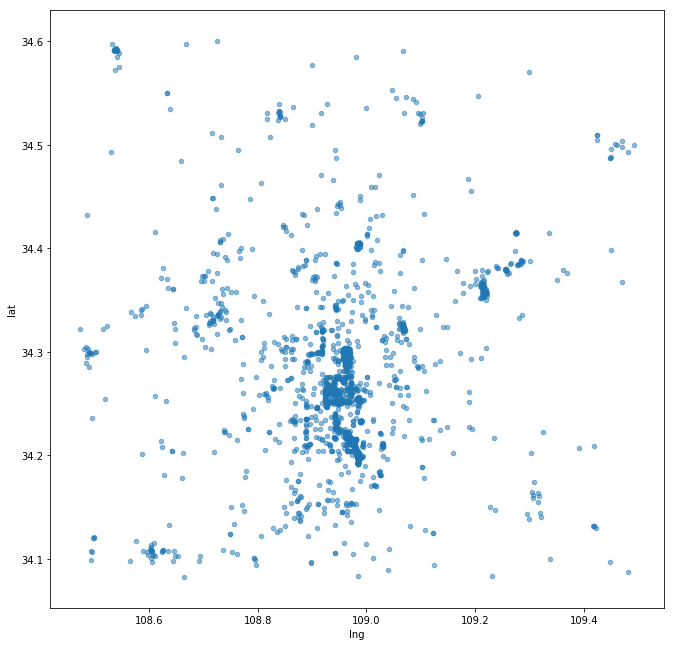

In [11]:
for filename in os.listdir(table_dir):
    if filename.endswith(".xlsx"):
        file = os.path.join(table_dir, filename)
        df = pd.read_excel(file, usecols=lambda x: 'Unnamed' not in x)
        if os.path.isfile('csvfile.csv'):
            os.remove('csvfile.csv')
        df.to_csv('csvfile.csv', encoding='utf-8', index=False)
        df.plot.scatter(alpha=0.5, figsize=(11, 11),x='lng', y='lat')
        arcpy.MakeXYEventLayer_management(
            'csvfile.csv', "lng", "lat", "temp", arcpy.SpatialReference
        (4326))
        arcpy.CopyFeatures_management("temp",  filename[:-5])
        arcpy.Delete_management("temp")
        print(u"Created Feature Class {0}".format(filename[:-5]))

### 生成六边形网格，用于聚合poi数据，大小为0.5平方公里

In [12]:
def GetWorkSpaceExtent():
    minX = 1000000000
    maxX = 0
    minY = 1000000000
    maxY = 0
    for featureClass in arcpy.ListFeatureClasses():
        minX = minX if arcpy.Describe(featureClass).extent.XMin > minX else arcpy.Describe(featureClass).extent.XMin
        maxX = maxX if arcpy.Describe(featureClass).extent.XMax < maxX else arcpy.Describe(featureClass).extent.XMax
        minY = minY if arcpy.Describe(featureClass).extent.YMin > minY else arcpy.Describe(featureClass).extent.YMin
        maxY = maxY if arcpy.Describe(featureClass).extent.YMax < maxY else arcpy.Describe(featureClass).extent.YMax
    return arcpy.Extent(minX, minY, maxX, maxY)

In [13]:
gridName = "hex"
hex_extent = GetWorkSpaceExtent()
spatial_ref = arcpy.SpatialReference(4326)
arcpy.GenerateTessellation_management(gridName, hex_extent, "HEXAGON", "0.5 SquareKilometers", spatial_ref)

<Result './poi_tables/poi_nb.gdb\\hex'>

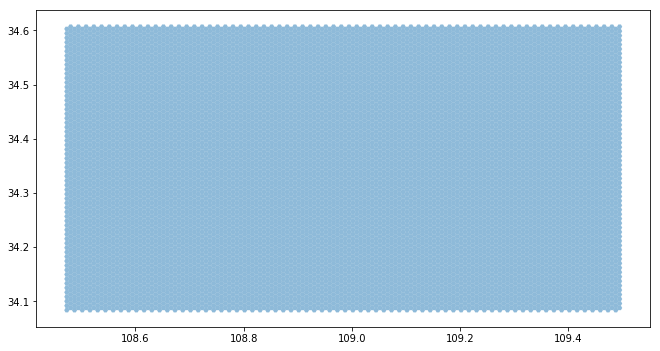

In [14]:
df = gpd.read_file(arcpy.env.workspace, layer=gridName)
df.plot(alpha=0.5, figsize=(11, 11))

### 将poi聚合到网格内

In [15]:
def CountPointsInGrids(gridName, poi):
        arcpy.SpatialJoin_analysis(gridName, poi, "temp", "JOIN_ONE_TO_ONE")
        arcpy.AlterField_management("temp", "Join_Count", poi+"_num")
        for field in arcpy.ListFields("temp"):
            if "_num" not in field.name and not field.required:
                arcpy.DeleteField_management("temp", field.name)
        arcpy.CopyFeatures_management("temp", gridName)
        arcpy.Delete_management("temp")
        print("Layer {0} has been processed".format(poi))

In [16]:
for l in arcpy.ListFeatureClasses():
    desc = arcpy.Describe(l)
    if desc.shapeType == "Point":
        CountPointsInGrids(gridName, l)

Layer edu has been processed
Layer food has been processed
Layer infrastructure has been processed
Layer medicine has been processed
Layer shopping has been processed
Layer siteseeing has been processed


### 删除poi数量为0的网格

In [17]:
arcpy.MakeFeatureLayer_management(gridName, "grid_layer")
expression = ""
for field in arcpy.ListFields(gridName):
    if "_num" in field.name:
        expression += field.name + " < 1 AND "
expression = expression[:-5]
print ("expression used: {0}".format(expression))
arcpy.SelectLayerByAttribute_management("grid_layer",
                                        "NEW_SELECTION",
                                        expression)
print("Deleting {0} rows in {1}".format(
    arcpy.GetCount_management("grid_layer").getOutput(0), gridName))
if int(arcpy.GetCount_management("grid_layer").getOutput(0)) > 0:
    arcpy.DeleteRows_management("grid_layer")

expression used: siteseeing_num < 1 AND shopping_num < 1 AND medicine_num < 1 AND infrastructure_num < 1 AND food_num < 1 AND edu_num < 1
Deleting 5540 rows in hex


### 网格添加具有POI权重的字段

In [18]:
weights = {
            "edu_num": 2,
            "food_num": 3,
            "siteseeing_num": 5,
            "shopping_num": 3,
            "infrastructure_num": 1,
            "medicine_num": 1,
        }
all_field = "count_all"
arcpy.AddField_management(gridName, all_field, "FLOAT")
expression = ""
for field in arcpy.ListFields(gridName):
    if "_num" in field.name:
        if (field.name in weights):
            expression += "!{0}! * {1} + ".format(
                field.name, weights[field.name])
        else:
            expression += "!{0}! + ".format(field.name)
expression = expression[:-3]
print("Weighted Expression: {0}".format(expression))
arcpy.CalculateField_management(
    gridName, all_field, expression, "PYTHON_9.3", "")
print("Weighted field added")

Weighted Expression: !siteseeing_num! * 5 + !shopping_num! * 3 + !medicine_num! * 1 + !infrastructure_num! * 1 + !food_num! * 3 + !edu_num! * 2
Weighted field added


### 使用所有的网格进行热点分析

In [19]:
arcpy.OptimizedHotSpotAnalysis_stats(gridName, "HSAnalysis_All", all_field)

<Result './poi_tables/poi_nb.gdb\\HSAnalysis_All'>

### 对西安行政区划内进行热点分析

In [20]:
districts = "./xian/xian_district.shp"

In [21]:
arcpy.MakeFeatureLayer_management(districts, "districts_layer")

<Result 'districts_layer'>

In [22]:
arcpy.MakeFeatureLayer_management(gridName, "hex_layer")

<Result 'hex_layer'>

In [23]:
arcpy.SelectLayerByLocation_management(
                "hex_layer", "intersect", "districts_layer")

<Result 'hex_layer'>

In [24]:
arcpy.OptimizedHotSpotAnalysis_stats(
                "hex_layer", "HSAnalysis_XIAN", all_field)

<Result './poi_tables/poi_nb.gdb\\HSAnalysis_XIAN'>

### 针对西安市内各区进行热点分析

In [25]:
with arcpy.da.SearchCursor("districts_layer", ['FID', 'Name']) as cursor:
    for row in cursor:
        arcpy.SelectLayerByAttribute_management("districts_layer",
                                                "NEW_SELECTION",
                                                "FID = " + str(row[0]))
        arcpy.SelectLayerByLocation_management(
            "hex_layer", "intersect", "districts_layer")
        num = int(arcpy.GetCount_management("hex_layer")[0])
        print("In total {0} grids".format(num))
        # 少于30个网格无法进行热点分析
        if num > 30:
            arcpy.OptimizedHotSpotAnalysis_stats("hex_layer", "HSAnalysis_{0}".format(row[1]), all_field)
            print("Hex grids within {0} analyzed, output layer HSAnalysis_{0}".format(row[1]))
        else:
            print("Not enough grids to analyze")

In total 8 grids
Not enough grids to analyze
In total 437 grids
Hex grids within Lintong analyzed, output layer HSAnalysis_Lintong
In total 590 grids
Hex grids within Changan analyzed, output layer HSAnalysis_Changan
In total 411 grids
Hex grids within Baqiao analyzed, output layer HSAnalysis_Baqiao
In total 404 grids
Hex grids within Weiyang analyzed, output layer HSAnalysis_Weiyang
In total 285 grids
Hex grids within Yanta analyzed, output layer HSAnalysis_Yanta
In total 58 grids
Hex grids within Beilin analyzed, output layer HSAnalysis_Beilin
In total 92 grids
Hex grids within Lianhu analyzed, output layer HSAnalysis_Lianhu
In total 70 grids
Hex grids within Xincheng analyzed, output layer HSAnalysis_Xincheng
